In [31]:
import random
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import torchaudio.transforms as T
from pydub import AudioSegment

torch.random.manual_seed(0)


def plot_waveform(waveform, sample_rate, title):
    waveform = waveform.numpy()  # Convert from tensor to numpy array
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    # Handle multiple channels
    fig, axes = plt.subplots(num_channels, 1, figsize=(10, 4 * num_channels))
    if num_channels == 1:
        axes = [axes]  # Ensure axes is always a list

    for i, ax in enumerate(axes):
        ax.plot(time_axis, waveform[i], linewidth=1)
        ax.set_title(f'{title} - Channel {i + 1}')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Amplitude')
        ax.grid(True)

    plt.tight_layout()


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [32]:
def plot_waveform(ax, waveform, sample_rate, title):
    num_samples = waveform.shape[1]
    time_axis = np.arange(0, num_samples) / sample_rate
    ax.plot(time_axis, waveform[0].numpy())
    ax.set_title(f"{title} Waveform")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude")
    ax.set_ylim([-1, 1])  # Set y-axis limits for amplitude
    ax.grid(True)


def plot_spectrogram(ax, waveform, sample_rate, n_fft, hop_length, title, spec_min_db, spec_max_db):
    spectrogram = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        hop_length=hop_length
    )(waveform)
    spec_db = torch.log10(spectrogram + 1e-9).mul(20).numpy()
    if spec_db.ndim == 3:
        spec_db = spec_db[0]
    num_samples = waveform.shape[1]
    im = ax.imshow(spec_db, aspect='auto', origin='lower', vmin=spec_min_db, vmax=spec_max_db,
                   extent=[0, num_samples / sample_rate, 0, sample_rate / 2])
    ax.set_title(f"{title} Spectrogram")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Frequency (Hz)")
    return im


def plot_mel_spectrogram(ax, waveform, sample_rate, n_fft, hop_length, n_mels, title, mel_min_db, mel_max_db):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )(waveform)
    mel_spec_db = torch.log10(mel_spectrogram + 1e-9).mul(20).numpy()
    if mel_spec_db.ndim == 3:
        mel_spec_db = mel_spec_db[0]
    num_samples = waveform.shape[1]
    im = ax.imshow(mel_spec_db, aspect='auto', origin='lower', vmin=mel_min_db, vmax=mel_max_db,
                   extent=[0, num_samples / sample_rate, 0, n_mels])
    ax.set_title(f"{title} Mel Spectrogram")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Mel Frequency")
    return im


def visualize_audio(file_path, custom_title=None, n_mels=64, n_fft=1024, hop_length=512,
                    spec_min_db=-100, spec_max_db=20, mel_min_db=-100, mel_max_db=20):
    # Load the .wav or .mp3 file
    waveform, sample_rate = torchaudio.load(file_path)

    # Extract file name without extension to use as default title
    file_name = Path(file_path).stem
    title = custom_title or file_name

    # Create a figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

    # Plot the waveform
    plot_waveform(ax1, waveform, sample_rate, title)

    # Plot the spectrogram
    im2 = plot_spectrogram(ax2, waveform, sample_rate, n_fft, hop_length, title, spec_min_db, spec_max_db)
    plt.colorbar(im2, ax=ax2, format='%+2.0f dB')

    # Plot the Mel spectrogram
    im3 = plot_mel_spectrogram(ax3, waveform, sample_rate, n_fft, hop_length, n_mels, title, mel_min_db, mel_max_db)
    plt.colorbar(im3, ax=ax3, format='%+2.0f dB')

    plt.tight_layout()
    plt.show()


def plot_audio_waveform(file_path, title=None):
    """Plot the waveform of an audio file."""
    waveform, sample_rate = torchaudio.load(file_path)
    num_samples = waveform.shape[1]
    time_axis = np.arange(0, num_samples) / sample_rate
    title = title or Path(file_path).stem

    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, waveform[0].numpy(), label='Waveform')
    plt.title(f"{title} Waveform")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.ylim([-1, 1])
    plt.grid(True)
    plt.show()


def plot_audio_spectrogram(file_path, n_fft=1024, hop_length=512, spec_min_db=-100, spec_max_db=20, title=None):
    """Plot the spectrogram of an audio file."""
    waveform, sample_rate = torchaudio.load(file_path)
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)(waveform)
    spec_db = torch.log10(spectrogram + 1e-9).mul(20).numpy()
    title = title or Path(file_path).stem

    plt.figure(figsize=(10, 6))
    plt.imshow(spec_db[0], aspect='auto', origin='lower', vmin=spec_min_db, vmax=spec_max_db,
               extent=[0, waveform.shape[1] / sample_rate, 0, sample_rate / 2])
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{title} Spectrogram")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.show()


def plot_audio_mel_spectrogram(file_path, n_fft=1024, hop_length=512, n_mels=64, mel_min_db=-100, mel_max_db=20,
                               title=None, augment=False):
    """Plot the Mel spectrogram of an audio file."""
    waveform, sample_rate = torchaudio.load(file_path)
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft,
                                                           hop_length=hop_length, n_mels=n_mels)(waveform)
    mel_spec_db = torch.log10(mel_spectrogram + 1e-9).mul(20).numpy()
    title = title or Path(file_path).stem
    if augment:
        waveform = augment_audio(waveform, sample_rate)

    plt.figure(figsize=(10, 6))
    plt.imshow(mel_spec_db[0], aspect='auto', origin='lower', vmin=mel_min_db, vmax=mel_max_db,
               extent=[0, waveform.shape[1] / sample_rate, 0, n_mels])
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"{title} Mel Spectrogram")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Mel Frequency")
    plt.show()


def augment_audio(waveform, sample_rate):
    """Apply random audio augmentations."""
    transforms = [
        lambda x: T.Vol(0.5 + random.uniform(0.5, 1.5))(x),  # Adjust volume
        lambda x: T.TimeStretch()(x) if x.shape[0] == 1 else x,  # Time-stretch for mono audio
        lambda x: T.PitchShift(sample_rate=sample_rate, n_steps=random.randint(-2, 2))(x),  # Pitch shift
        lambda x: x + (torch.randn_like(x) * 1.005),  # Add noise
    ]

    # Randomly apply one or more transforms
    waveform = transforms[3](waveform)

    return waveform


def get_random_file(folder_path):
    # Get all files in the folder (excluding subdirectories)
    folder = Path(folder_path)
    files = [file for file in folder.rglob('*') if file.is_file()]

    if not files:
        print("No files found in the specified folder.")
        return

    # Return a random file
    choice = random.choice(files)
    print(choice)
    return choice

In [33]:
def compare_audio_files(file1, file2, titles=None):
    """
    Compare two audio files by plotting their waveform, spectrogram, Mel spectrogram,
    and MFCCs side by side.
    
    Args:
        file1 (str): Path to the first audio file.
        file2 (str): Path to the second audio file.
        titles (list, optional): Custom titles for the plots [title1, title2].
    """
    titles = titles or [Path(file1).stem, Path(file2).stem]

    waveform1, sample_rate1 = torchaudio.load(file1)
    waveform2, sample_rate2 = torchaudio.load(file2)

    fig, axes = plt.subplots(4, 2, figsize=(20, 18))  # Adjusted to include MFCCs

    # Plot waveforms
    plot_waveform(axes[0, 0], waveform1, sample_rate1, titles[0])
    plot_waveform(axes[0, 1], waveform2, sample_rate2, titles[1])

    # Plot spectrograms
    im1 = plot_spectrogram(axes[1, 0], waveform1, sample_rate1, n_fft=1024, hop_length=512,
                           title=titles[0], spec_min_db=-100, spec_max_db=20)
    im2 = plot_spectrogram(axes[1, 1], waveform2, sample_rate2, n_fft=1024, hop_length=512,
                           title=titles[1], spec_min_db=-100, spec_max_db=20)
    fig.colorbar(im1, ax=axes[1, 0], format='%+2.0f dB')
    fig.colorbar(im2, ax=axes[1, 1], format='%+2.0f dB')

    # Plot Mel spectrograms
    im3 = plot_mel_spectrogram(axes[2, 0], waveform1, sample_rate1, n_fft=1024, hop_length=512,
                               n_mels=64, title=titles[0], mel_min_db=-100, mel_max_db=20)
    im4 = plot_mel_spectrogram(axes[2, 1], waveform2, sample_rate2, n_fft=1024, hop_length=512,
                               n_mels=64, title=titles[1], mel_min_db=-100, mel_max_db=20)
    fig.colorbar(im3, ax=axes[2, 0], format='%+2.0f dB')
    fig.colorbar(im4, ax=axes[2, 1], format='%+2.0f dB')

    # Plot MFCCs
    waveform1 = waveform1.squeeze().numpy()
    waveform2 = waveform2.squeeze().numpy()

    if waveform1.ndim > 1:
        waveform1 = waveform1.mean(axis=0)  # Convert to mono if stereo
    if waveform2.ndim > 1:
        waveform2 = waveform2.mean(axis=0)

    # Compute MFCCs
    mfcc1 = librosa.feature.mfcc(y=waveform1, sr=sample_rate1, n_mfcc=13)
    mfcc2 = librosa.feature.mfcc(y=waveform2, sr=sample_rate2, n_mfcc=13)

    # Plot MFCCs
    im5 = librosa.display.specshow(mfcc1, x_axis='time', sr=sample_rate1, hop_length=512, ax=axes[3, 0],
                                   cmap='coolwarm')
    im6 = librosa.display.specshow(mfcc2, x_axis='time', sr=sample_rate2, hop_length=512, ax=axes[3, 1],
                                   cmap='coolwarm')
    axes[3, 0].set_title(f'{titles[0]} MFCCs')
    axes[3, 1].set_title(f'{titles[1]} MFCCs')
    fig.colorbar(im5, ax=axes[3, 0], format='%+2.0f')
    fig.colorbar(im6, ax=axes[3, 1], format='%+2.0f')

    # Set subplot labels
    labels = ["Waveform", "Spectrogram", "Mel Spectrogram", "MFCCs"]
    for i in range(3):  # Updated to 5 rows
        axes[i, 0].set_ylabel(labels[i])

    plt.tight_layout()
    plt.show()


In [34]:
def extract_mfcc(segment):
    audio = AudioSegment.from_wav(segment)
    audio_data = np.array(audio.get_array_of_samples(), dtype=np.float32)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=audio.frame_rate, n_mfcc=13)
    return mfccs


def plot_mfcc(mfcc):
    mfccs = extract_mfcc(active_1)

    # Assuming MFCCs is your input signal
    S = librosa.feature.melspectrogram(y=mfccs, sr=22050, n_mels=128)

    # Convert to decibels
    S_db = librosa.power_to_db(S, ref=np.max)

    # Plot mel spectrogram
    S_db = np.squeeze(S_db)  # This removes any singleton dimensions
    fig, ax = plt.subplots(figsize=(10, 6))
    img = librosa.display.specshow(S_db, x_axis='time', ax=ax)

    ax.set(title='MFCCs')
    fig.colorbar(img, ax=ax)
    plt.show()

In [35]:
active_1 = get_random_file("./data/audio_output/active")
active_2 = get_random_file("./data/audio_output/active")
active_3 = get_random_file("./data/audio_output/active")
# swarming_1 = get_random_file("./data/audio_output/swarm")
missing_queen = get_random_file("./data/audio_output/missing_queen")
# pre_swarm = get_random_file("./data/audio_output/pre_swarm")
no_bee = get_random_file("./data/audio_output/no_bee")
queen_hatching = get_random_file("./data/audio_output/queen_hatching")
sick_varroa = get_random_file("./data/audio_output/sick_varroa")


data/audio_output/active/active_9009_0.wav
data/audio_output/active/active_8334_175.wav
data/audio_output/active/active_8334_3.wav
data/audio_output/missing_queen/missing_queen_4722_0.wav
data/audio_output/no_bee/no_bee_5304_0.wav
data/audio_output/queen_hatching/queen_hatching_4865_5.wav
data/audio_output/sick_varroa/sick_varroa_4864_1.wav


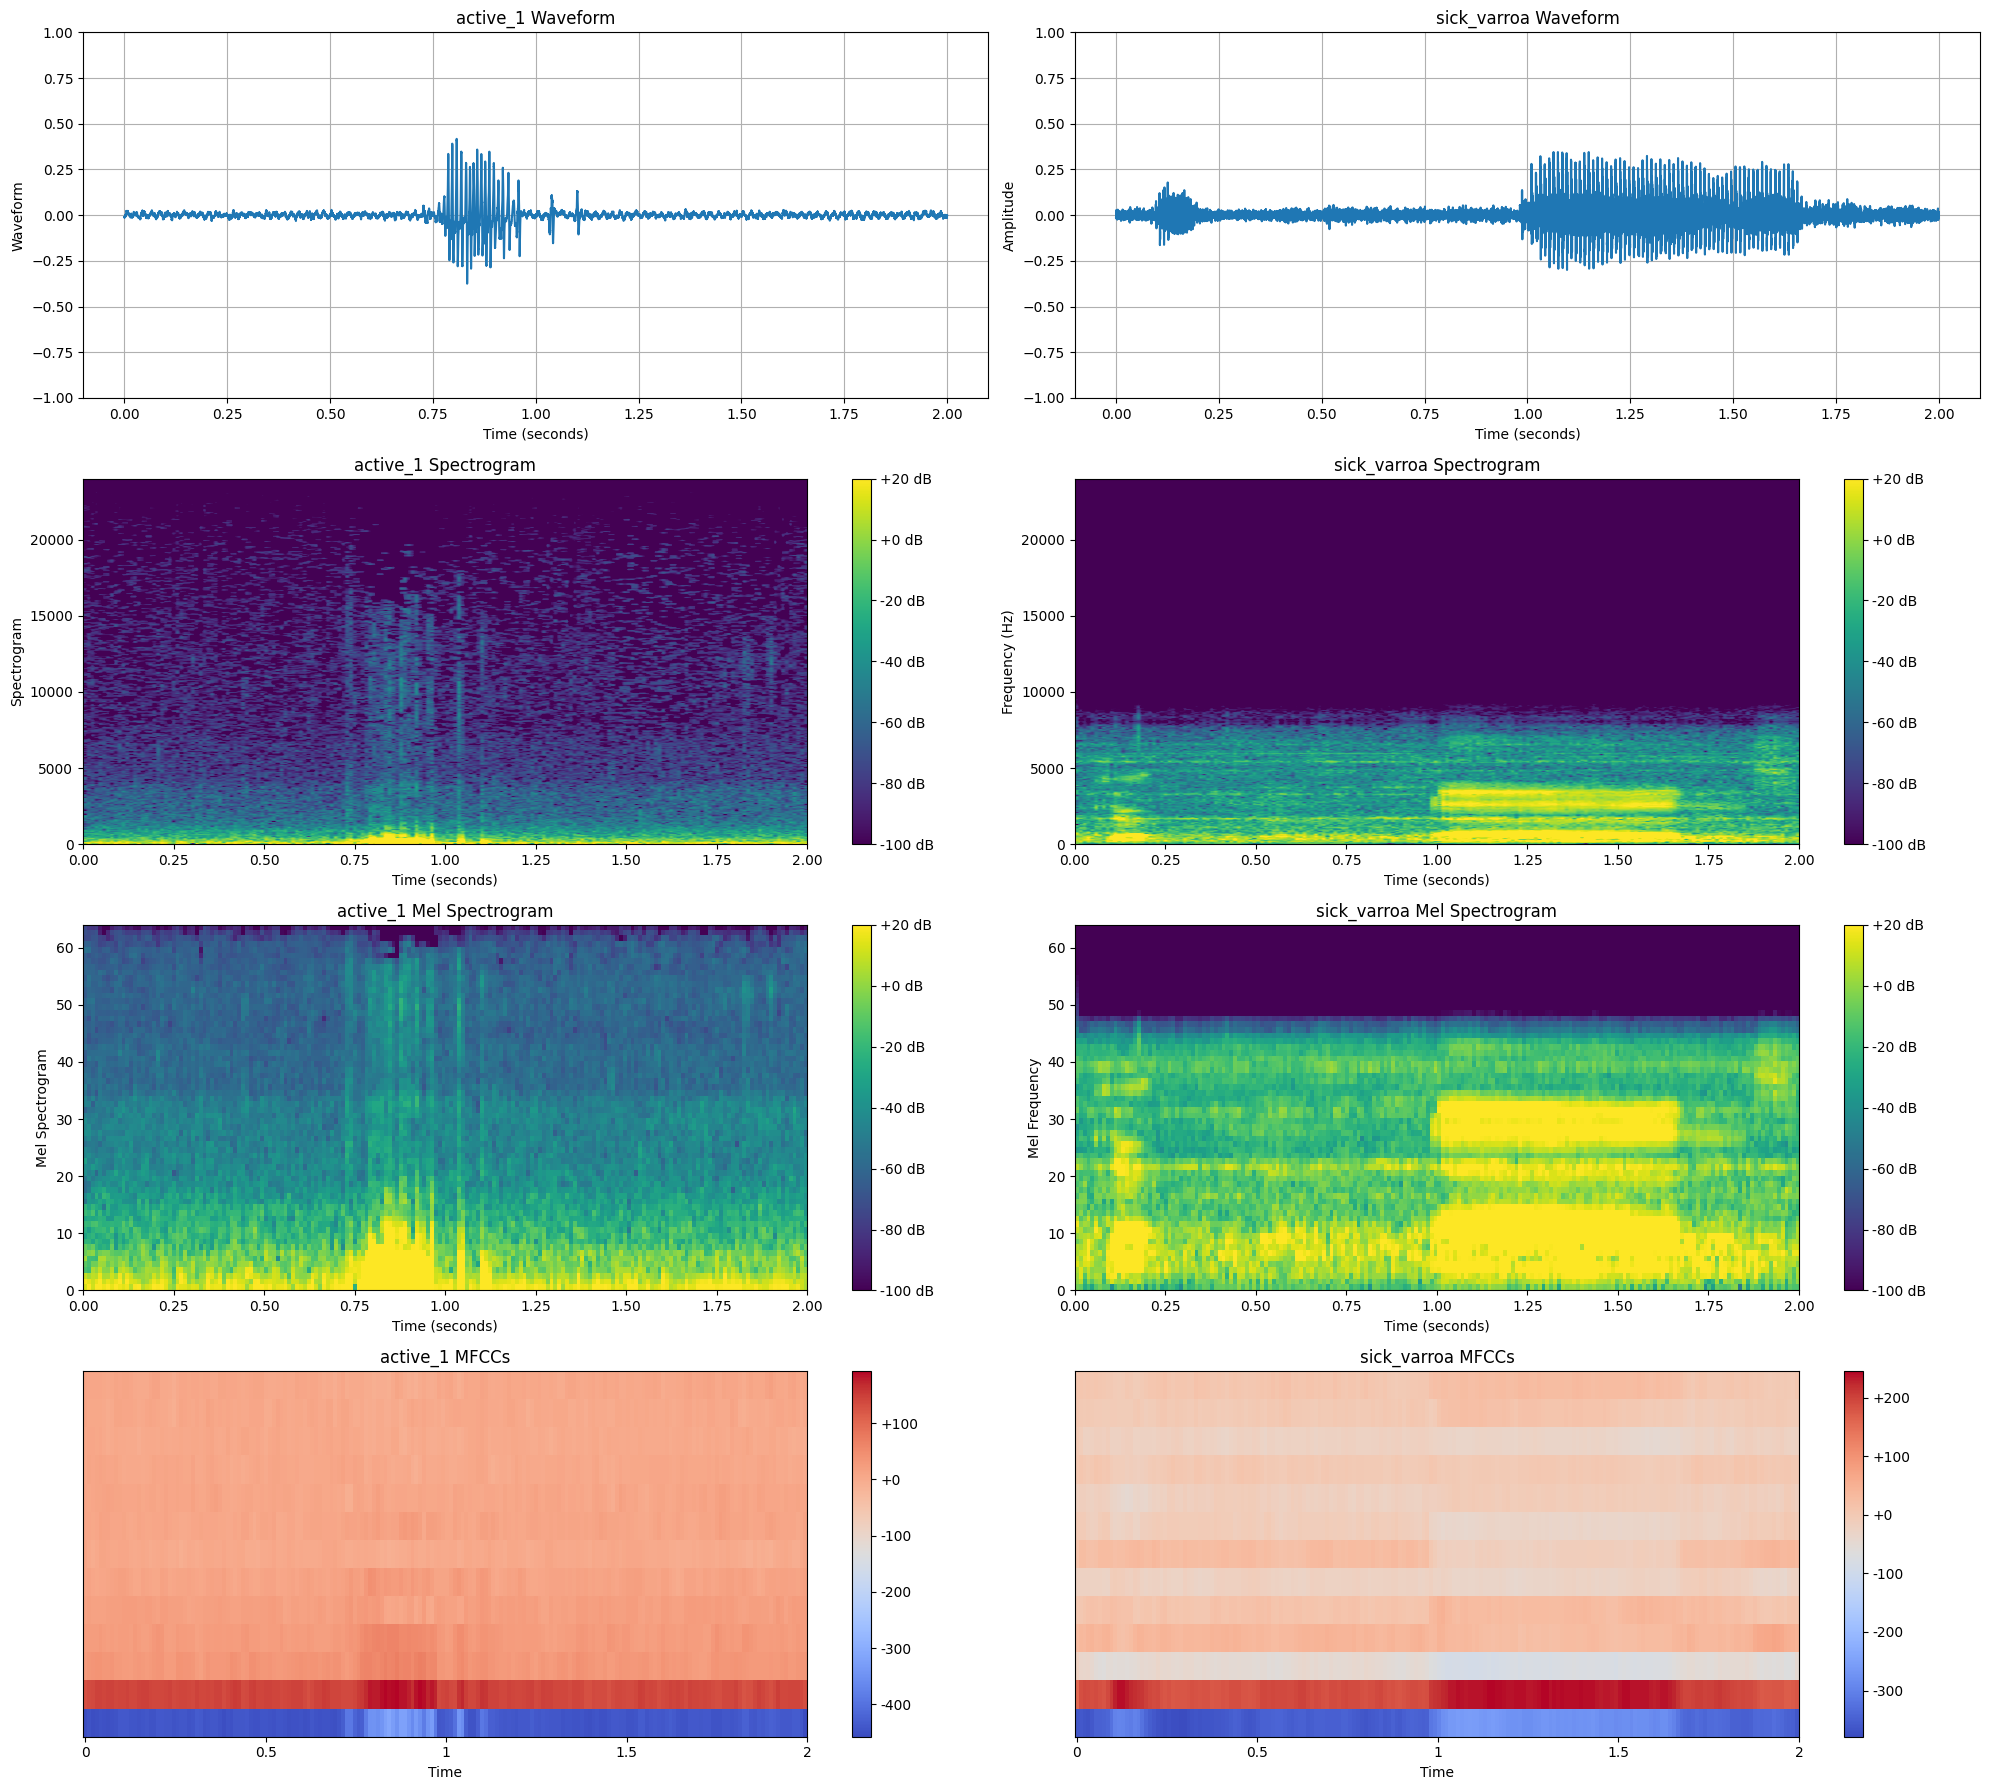

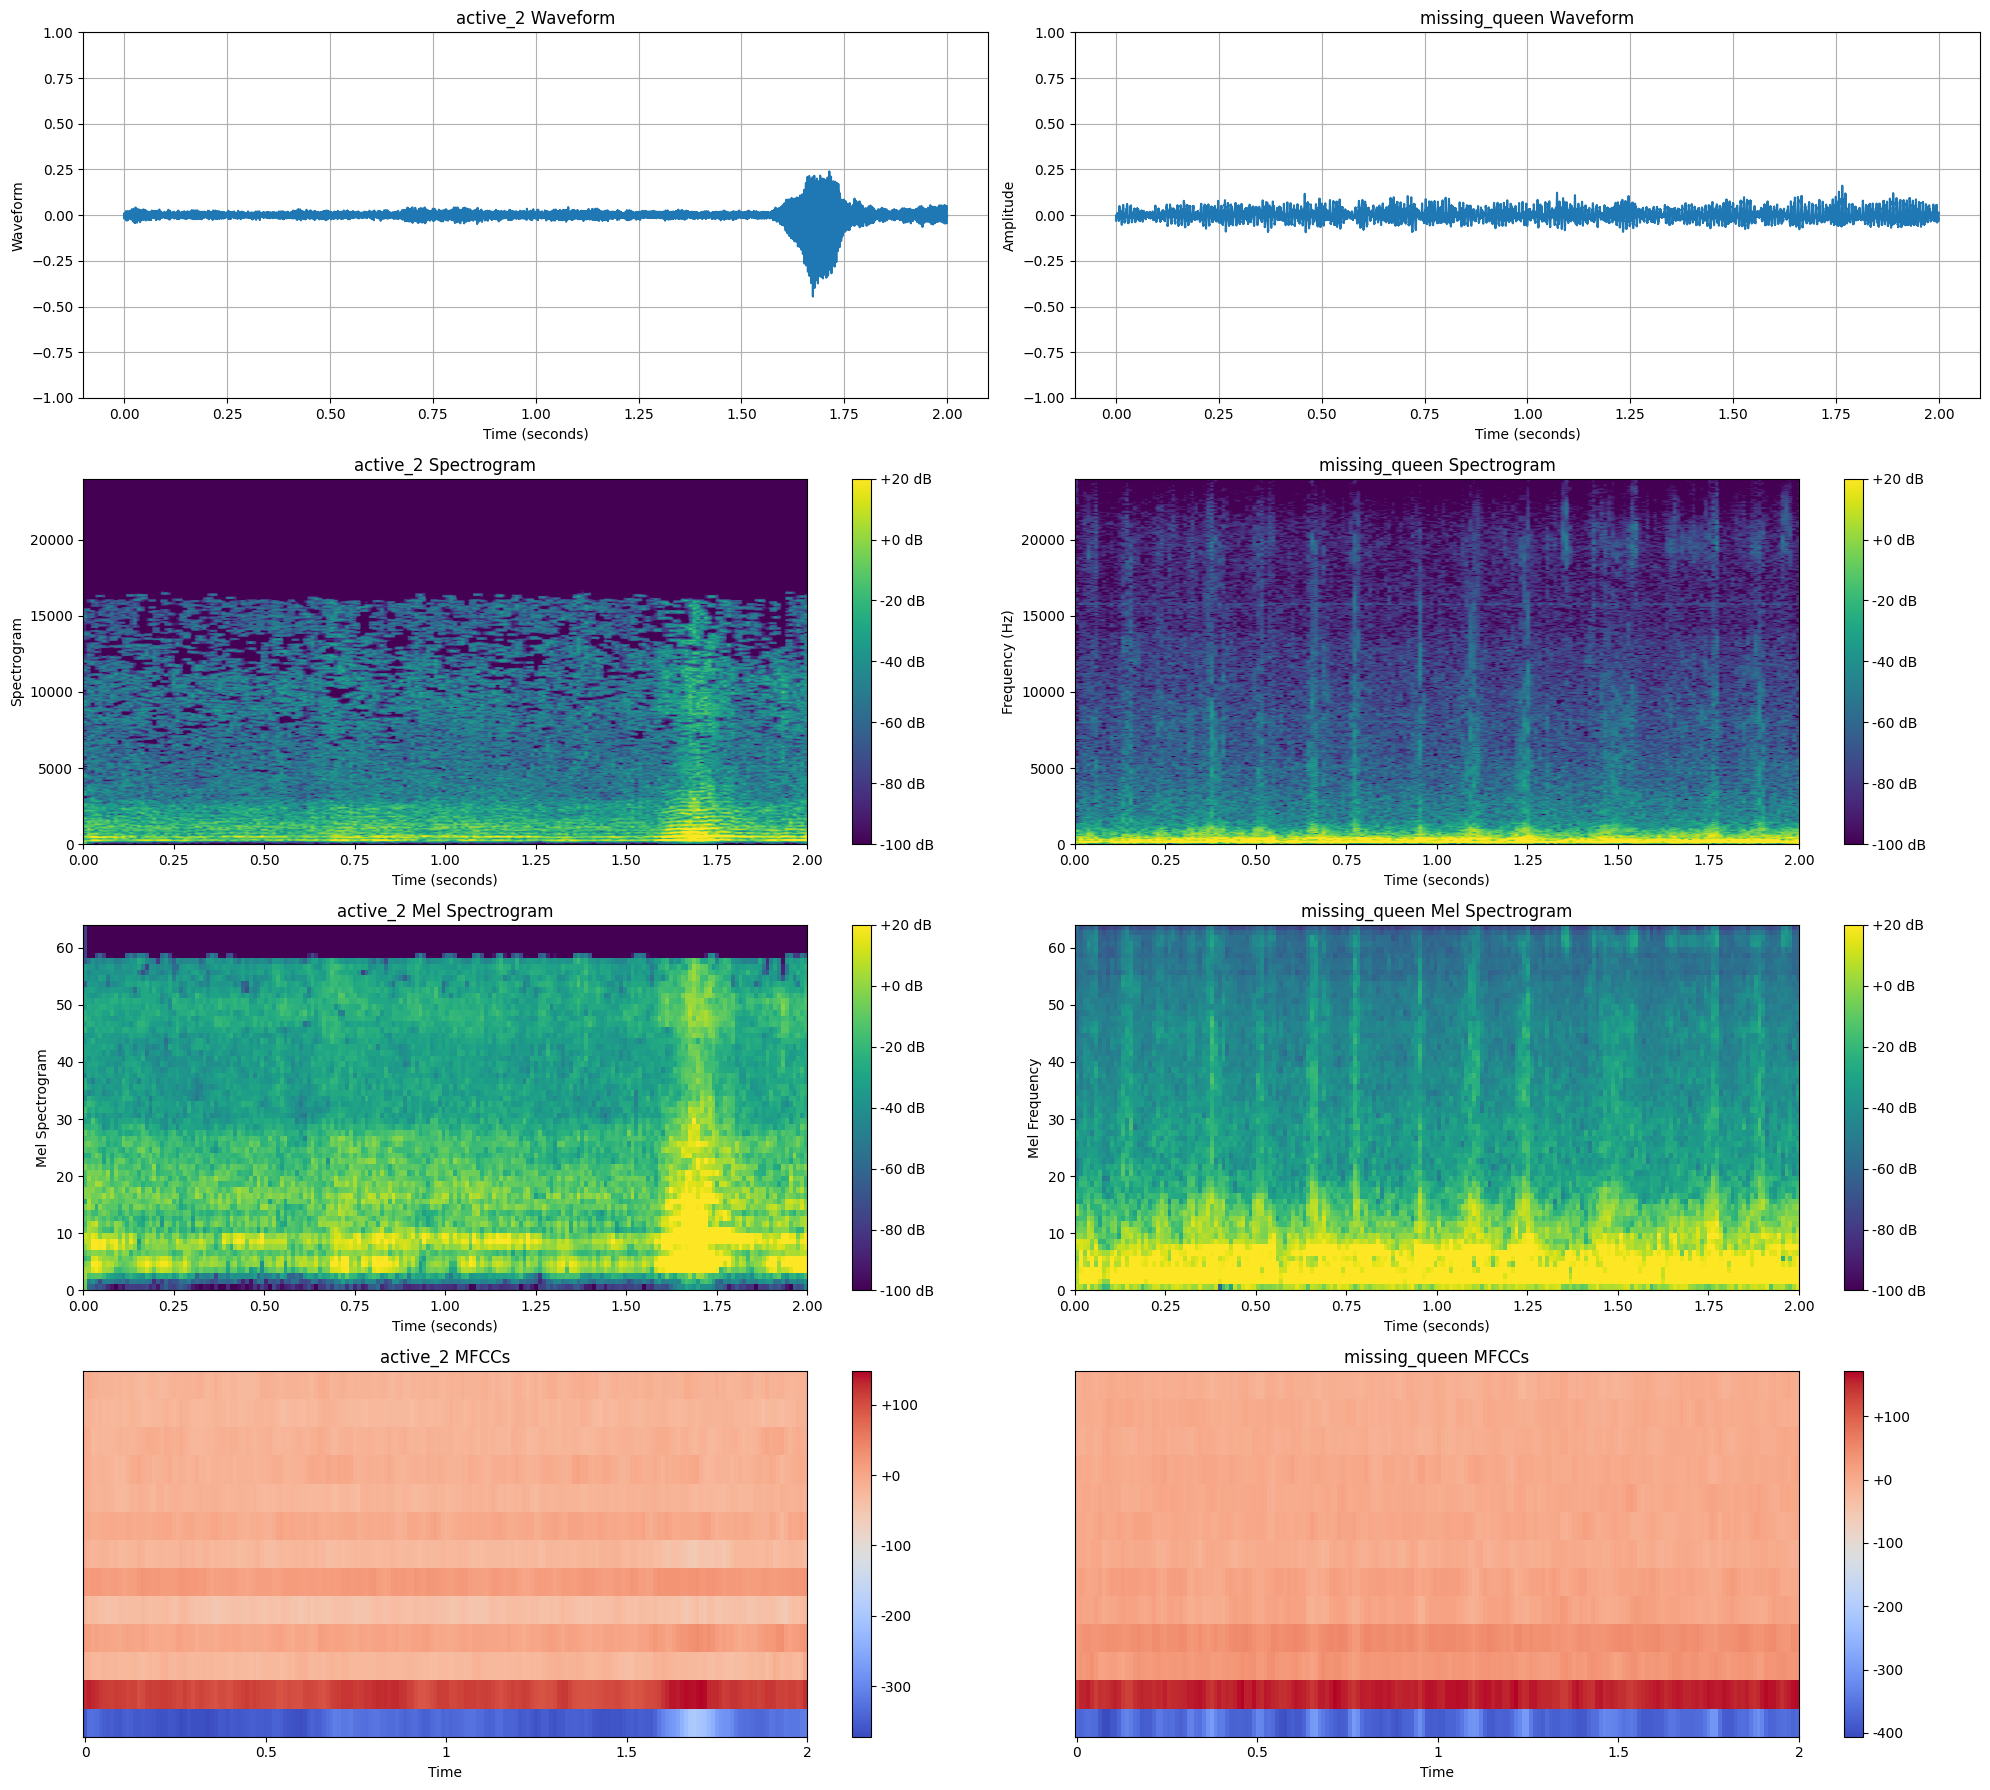

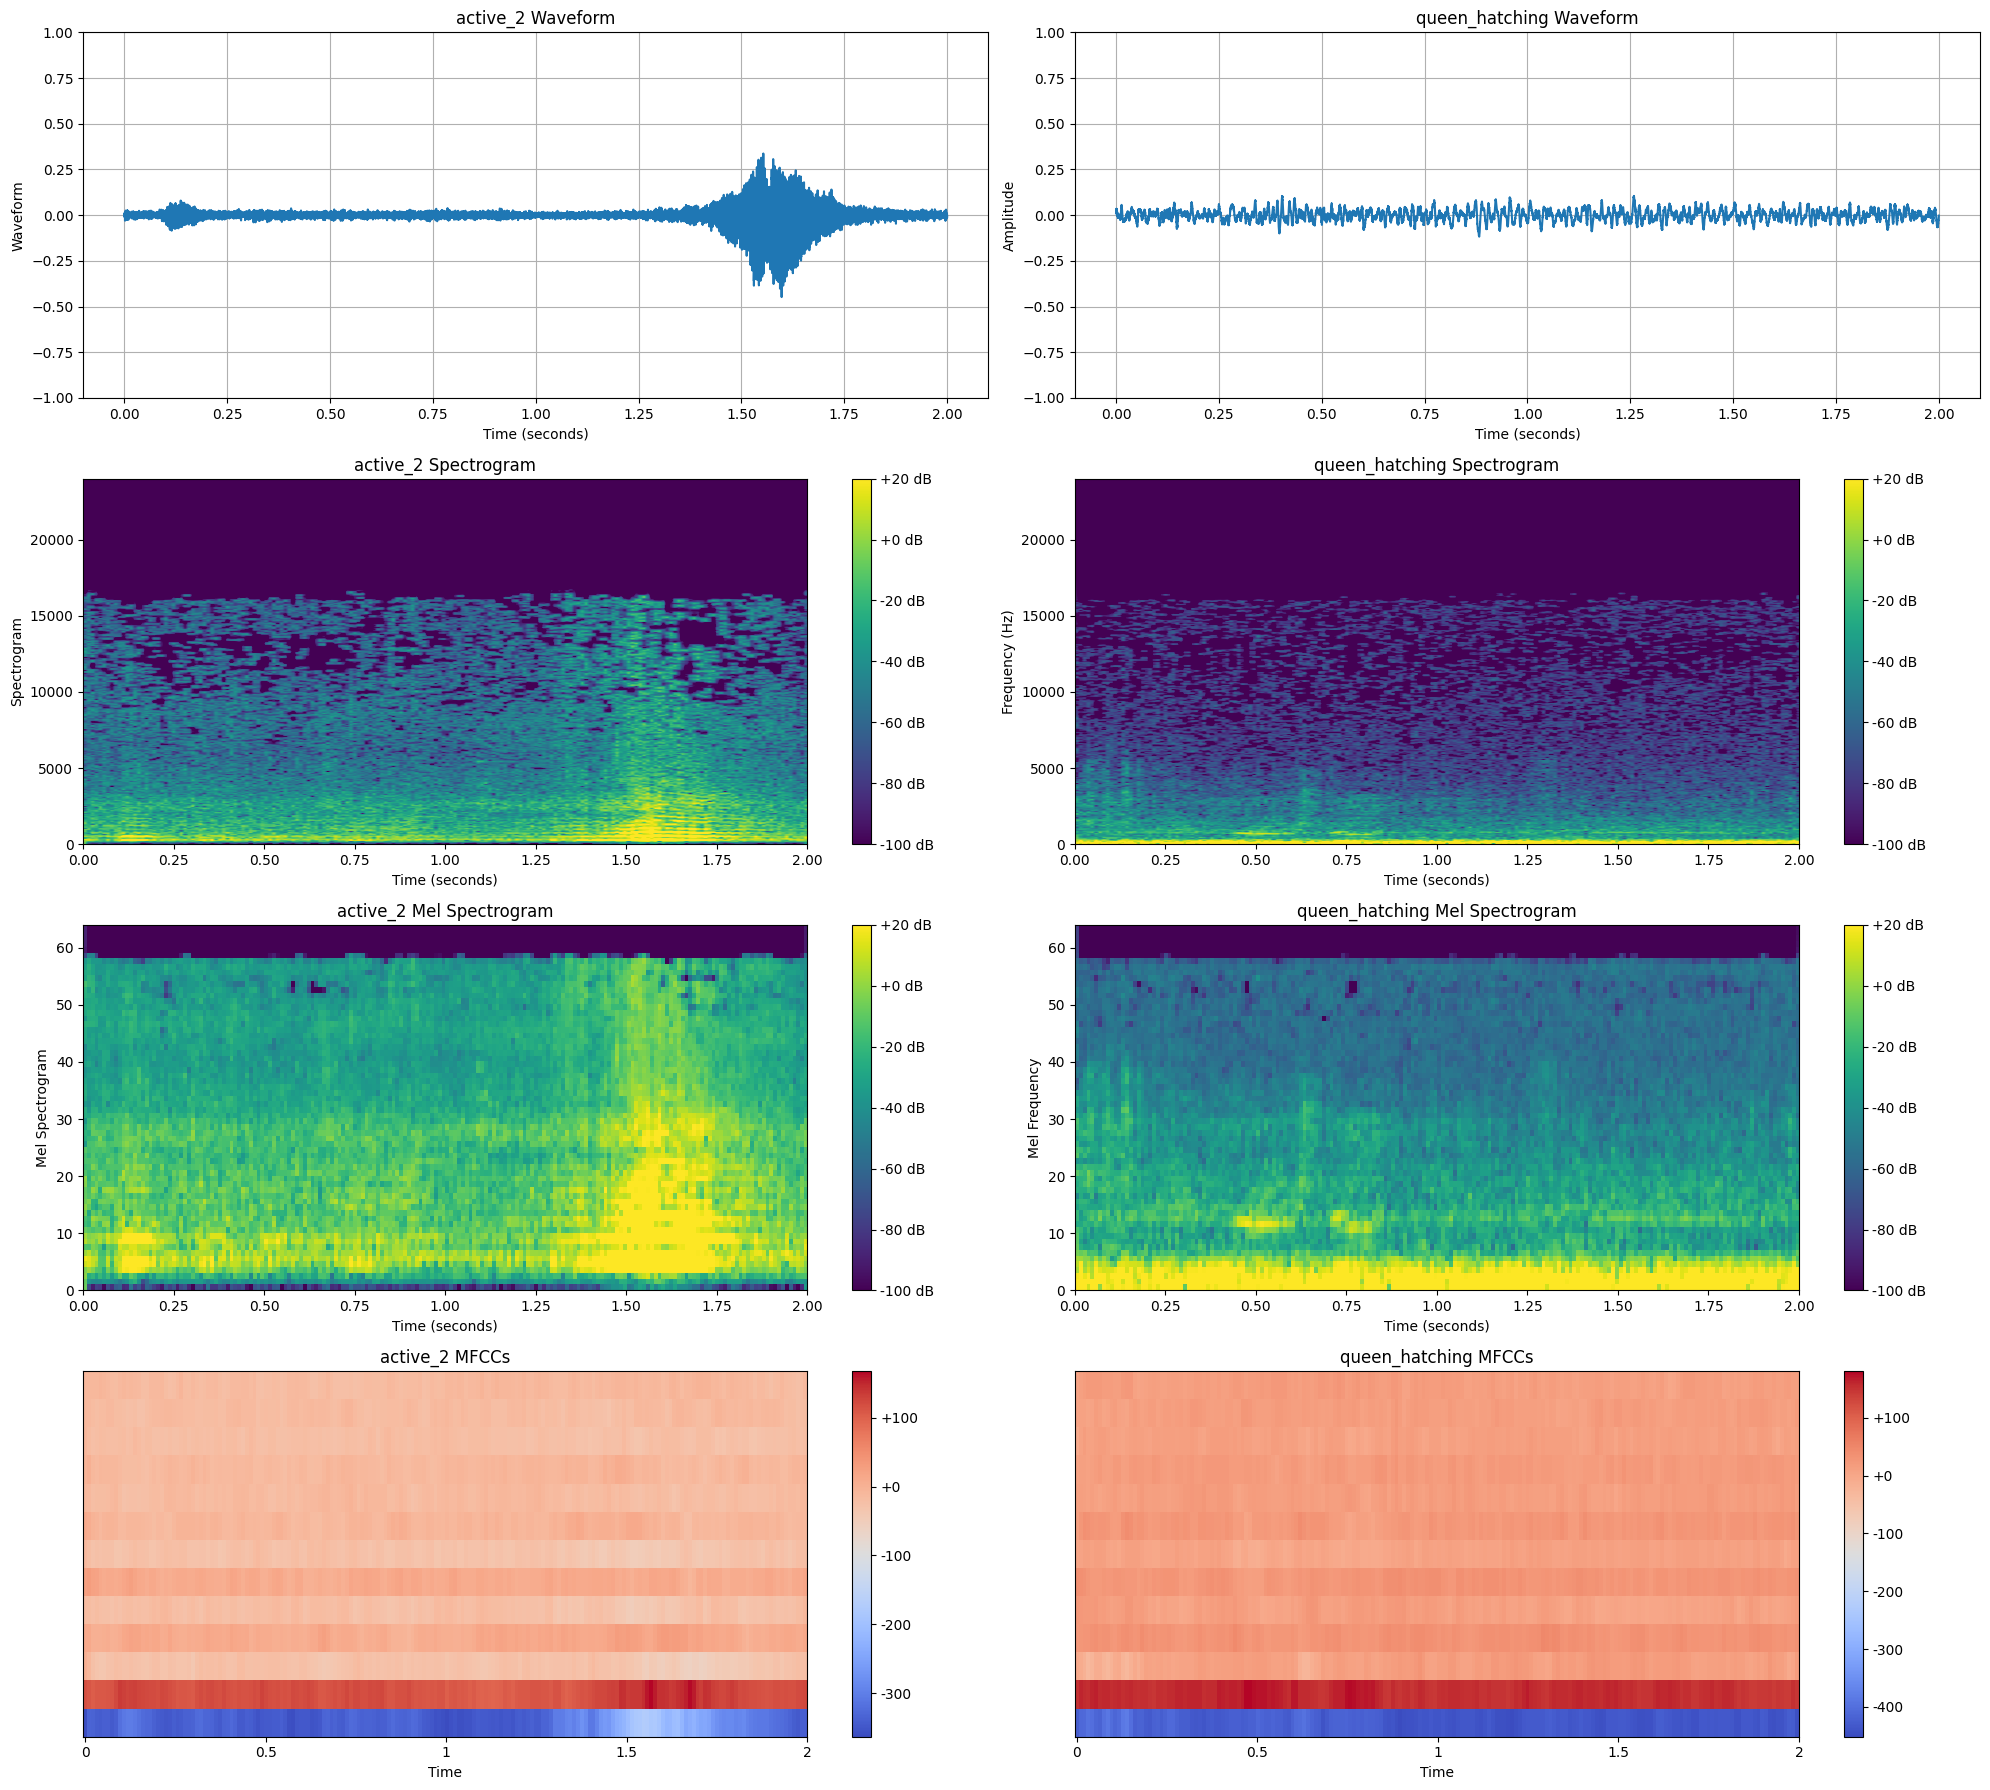

In [36]:
compare_audio_files(active_1, sick_varroa, titles=["active_1", "sick_varroa"])
compare_audio_files(active_2, missing_queen, titles=["active_2", "missing_queen"])
compare_audio_files(active_3, queen_hatching, titles=["active_3", "queen_hatching"])
# compare_audio_files(active_3, no_bee, titles=["active_3", "no_bee"])
# compare_audio_files(missing_queen, pre_swarm, titles=["active_3", "no_bee"])
